## Nutrient Demands



### Introduction



In our last project we used data to estimate systems of food demand
using different datasets.  An output from that project was as set of
`cfe.Regression` objects; these bundle together both data and the results
from the demand system estimation, and can be used for prediction as
well.

Here we&rsquo;ll explore some of the uses of the `cfe.Regression` class, using
an instance created previously (as in Project 3).

After having estimated a demand system using data from our favorite country, we can imagine different counterfactual scenarios.  What if prices were different?  What if we give a cash transfer to a household?  What if school fees reduce the budget for food?  What are the consequences of any of these for diet & nutrition?

If you don&rsquo;t already have the latest version of the `CFEDemands` package
installed, grab it, along with some dependencies:



In [1]:
%pip install -r requirements.txt

  Using cached cfedemands-0.6.4.dev0-py2.py3-none-any.whl.metadata (1.6 kB)
  Using cached ConsumerDemands-0.4.3.dev0-py2.py3-none-any.whl.metadata (1.2 kB)
  Using cached eep153_tools-0.12.4-py2.py3-none-any.whl.metadata (363 bytes)
  Using cached python_gnupg-0.5.4-py2.py3-none-any.whl.metadata (2.0 kB)
  Using cached gspread_pandas-3.3.0-py2.py3-none-any.whl.metadata (10 kB)
  Using cached fsspec-2025.3.2-py3-none-any.whl.metadata (11 kB)
Using cached cfedemands-0.6.4.dev0-py2.py3-none-any.whl (45 kB)
Using cached ConsumerDemands-0.4.3.dev0-py2.py3-none-any.whl (12 kB)
Using cached eep153_tools-0.12.4-py2.py3-none-any.whl (4.9 kB)
Using cached python_gnupg-0.5.4-py2.py3-none-any.whl (21 kB)
Using cached gspread_pandas-3.3.0-py2.py3-none-any.whl (27 kB)
Using cached fsspec-2025.3.2-py3-none-any.whl (194 kB)
  Attempting uninstall: gspread_pandas
    Found existing installation: gspread-pandas 2.2.3
    Uninstalling gspread-pandas-2.2.3:
      Successfully uninstalled gspread-pandas-2

In [2]:
import pandas as pd
import cfe.regression as rgsn

In [3]:
import seaborn as sns

### From Sheet to DataFrame to Regression Object



In [4]:
US_Data = 'https://docs.google.com/spreadsheets/d/1q5aGdIXILMcY5AzwxwD9lnQa6dRnrOuAjvTJABGxHZs/edit?usp=sharing'

With the spreadsheet defined , grab it and define a couple of
dataframes. (Sheets should be shared with `students@eep153.iam.gserviceaccount.com`):



In [35]:
import pandas as pd
import numpy as np
from eep153_tools.sheets import read_sheets

x = read_sheets(US_Data,sheet='Food Expenditures 2021')
x["j"] = x["food_name"]
x = x.set_index(['i','t','m','j'])["grams"].squeeze()

# Household characteristics
d = read_sheets(US_Data,sheet="Household Characteristics 2021")
d.columns.name = 'k'
d["sex"] = d["sex"].map({"Female": 1, "Male": 0})
d['log_household'] = np.log(d['HH_size'])
d.drop("HH_size", axis= 1, inplace=True)

# Fill blanks with zeros
d = d.replace(np.nan,0)

# Expenditures x may have duplicate columns
x = x.T.groupby(['i','t','m','j']).sum()
x = x.replace(0,np.nan) # Replace zeros with missing

# Take logs of expenditures; call this y
y = np.log(x)
d.set_index(['i','t','m'],inplace=True)

In [30]:
#Add price data
p = read_sheets(US_Data, sheet = 'prices_adapted')
p = p[p['t'] == '2017/2018'][['t','j','m','price']]

i       t     m    j                                                           
130378  2021  USA  Caesar dressing                                                   4.90
                   Cheese, parmesan, dry grated                                      2.08
                   Chicken, ns as to part and cooking method, ns as to skin eat    170.10
                   Chicken, ns as to part and cooking method, skin not eaten       170.10
                   Coffee, brewed                                                  600.00
                                                                                    ...  
142310  2021  USA  Potato, mashed, ready-to-heat                                    31.25
                   Sugar substitute, sucralose, powder                               1.00
                   Vodka                                                            84.00
                   Water, bottled, plain                                           493.50
                   W

In [33]:
y.merge(p, lef = 'j')

AttributeError: 'Series' object has no attribute 'merge'

In [ ]:

# Change column names to actual unit values
p["u"] = "Kg"

p["m"] = "USA"

# Adjust price to per Kg from per g
p["price"] = p["price"] * 10

codes = read_sheets(US_Data, sheet = 'recipes')

codes = codes[["parent_foodcode", "parent_desc"]]
c = codes.groupby("parent_foodcode").first()
c.rename(columns = {"parent_foodcode": "j"})
p = p.join(c, on="j")
p_with_j = p # use later on for nutrition data
p = p.drop("j", axis=1)
p = p.rename(columns = {"parent_desc":"j"})

# Now prices
p = p.set_index(['t','m','j','u'])

# Compute medians of prices for particular time, place and unit
p = p.groupby(['t','m','j','u']).median()

# Just keep metric units
p = p.xs('Kg',level="u").squeeze().unstack('j')
# Identify the common keys between x_filtered.index.levels[-1] and p.columns
common_keys = p.columns.intersection(x_filtered.index.levels[-1])

# Now subset p with these keys and transpose the result.
p = p[common_keys].T
p.to_csv('2021_price.csv', index=False)

In [6]:
food_counts = y.groupby('j').count()
top_foods = food_counts.sort_values(ascending=False).head(500).index
x_filtered = x[x.index.get_level_values('j').isin(top_foods)]
y_filtered = y[y.index.get_level_values('j').isin(top_foods)]
common_ids = y_filtered.index.get_level_values('i').unique()
y_final = y_filtered[y_filtered.index.get_level_values('i').isin(common_ids)]
d_final = d[d.index.get_level_values('i').isin(common_ids)]

change sex to 1, 0 and and log HHs

This gives a dataframe of household characteristics $d$ with a simple structure.



In [6]:
d_final.head()

,,k,age,sex,log_household
i,t,m,,,
130378,2021,USA,43.0,0,1.386294
130379,2021,USA,66.0,0,0.693147
130380,2021,USA,44.0,1,1.945910
130381,2021,USA,5.0,1,0.693147
130382,2021,USA,2.0,0,1.386294


Also a dataframe of log expenditures $y$ with a similarly simple
structure.  Note that any expenditures of zero are dropped and
replaced with a missing value indicator.



In [7]:
y_final.head()

i       t     m    j                                                           
130378  2021  USA  Caesar dressing                                                 1.589235
                   Cheese, parmesan, dry grated                                    0.732368
                   Chicken, ns as to part and cooking method, ns as to skin eat    5.136386
                   Chicken, ns as to part and cooking method, skin not eaten       5.136386
                   Coffee, brewed                                                  6.396930
Name: grams, dtype: float64

Finally, construct a regression object:



In [8]:
r = rgsn.Regression(y=y_final, d=d_final, 
                    min_obs=10, min_prop_items=0.002)
r.predicted_expenditures()

i       t     m    j                          
130378  2021  USA  Apple, raw                     168.369996
                   Avocado, raw                    63.681381
                   Banana, raw                    122.454224
                   Blueberries, raw                56.321903
                   Butter, stick                   10.287870
                                                     ...    
142310  2021  USA  Water, bottled, plain          698.879345
                   Water, carbonated, flavored    274.895393
                   Water, tap                     550.892315
                   Watermelon, raw                 17.861946
                   Wine, red                      121.100769
Length: 408334, dtype: float64

In [9]:
r.to_pickle('US_regression_obj.pkl')

In [9]:
r = rgsn.read_pickle('US_regression_obj.pkl')

In [12]:
r.demands()

TypeError: _demands() missing 1 required positional argument: 'x'

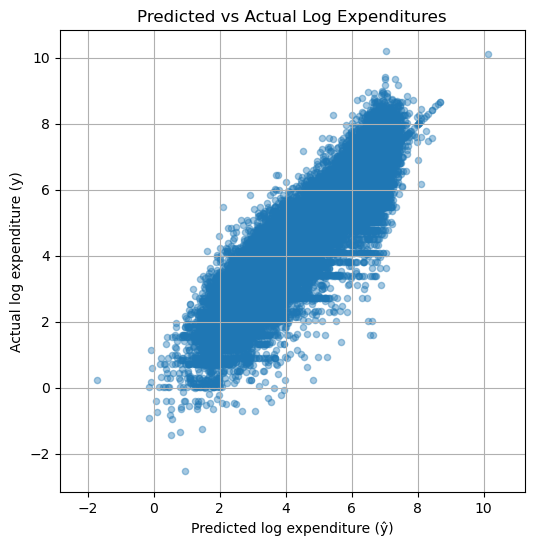

In [13]:
predicted = r.predicted_expenditures()
predicted.head()
%matplotlib inline
import matplotlib.pyplot as plt

# Create DataFrame of actual vs predicted log expenditures
df = pd.DataFrame({
    'y': y_final,
    'yhat': r.get_predicted_log_expenditures()
})

# Drop missing values (some may not match if data was trimmed)
df = df.dropna()

# Plot
df.plot.scatter(x='yhat', y='y', alpha=0.4, figsize=(6, 6))
plt.title("Predicted vs Actual Log Expenditures")
plt.xlabel("Predicted log expenditure (ŷ)")
plt.ylabel("Actual log expenditure (y)")
plt.grid(True)
plt.axis("equal")  # force square axes
plt.show()

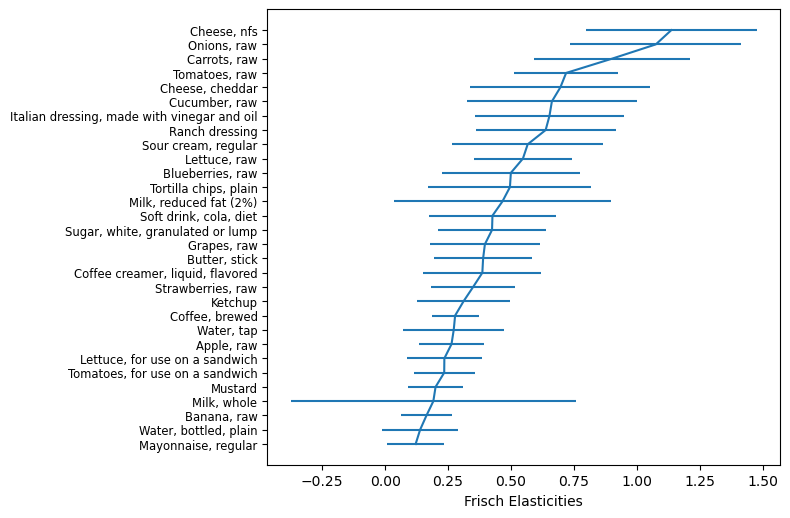

In [14]:
ax = r.graph_beta()

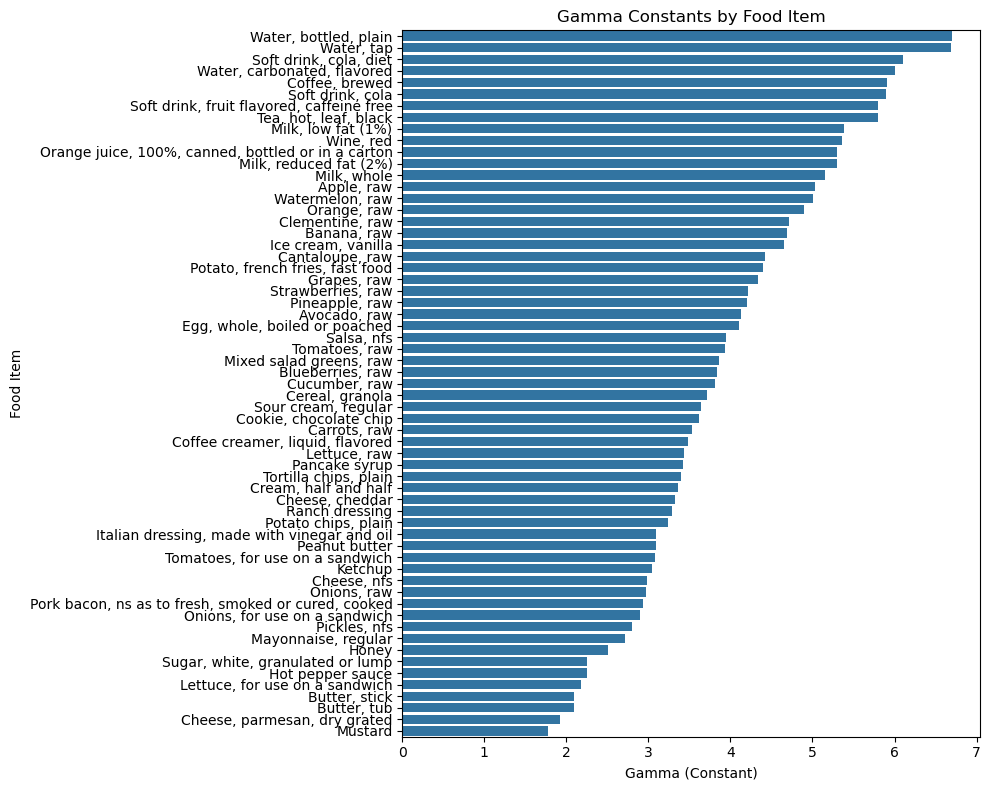

In [15]:
r.get_beta().sort_values(ascending=False)
foods_in_regression = r.beta.index.get_level_values('j').unique()
r.get_gamma().head()
gamma = r.get_gamma()
gamma_sorted = gamma.sort_values(by="Constant", ascending=False)
plt.figure(figsize=(10, 8))
sns.barplot(data=gamma_sorted, x="Constant", y="j")
plt.xlabel("Gamma (Constant)")
plt.ylabel("Food Item")
plt.title("Gamma Constants by Food Item")
plt.tight_layout()
plt.show()


### Additional Data



Using the data on household characteristics and (log) expenditures, we can estimate the demand system (`d`,=y=).  This gives us predictions of expenditures on different kinds of foods.  Then if we divide these expenditures by prices, we get predicted quantities of food.

However, here we&rsquo;re interested in nutritional outcomes, so we need a food conversion table:



In [17]:
nut = read_sheets(US_Data,sheet='nutrient_adapted')

nut = nut.set_index('j')
nut.columns.name = 'n'

nut = nut.apply(lambda x: pd.to_numeric(x,errors='coerce'))

We also want to establish when nutrition is *adequate* for households with different compositions.  For this, we want data on recommended dietary intakes:



In [19]:
rdi = read_sheets(US_Data,sheet='rdi_adapted')

rdi = rdi.set_index('n')
rdi.columns.name = 'k'

rdi = rdi.apply(lambda x: pd.to_numeric(x,errors='coerce'))

#### Pre-estimated Demand Systems



An instance `r` of `cfe.Regression` can be made persistent with
 `r.to_pickle('my_result.pickle')`, which saves the instance &ldquo;on disk&rdquo;, and can be loaded using `cfe.regression.read_pickle`.  We use  this method below to load data and demand system previously estimated for Uganda:



In [20]:
# Assumes you've already set this up e.g., in Project 3
r = rgsn.read_pickle('US_regression_obj.pkl')

#### Reference Prices



Choose reference prices.  Here we&rsquo;ll choose a particular year, and average prices across markets.  If you wanted to focus on particular market you&rsquo;d do this differently.



In [21]:
# Reference prices chosen from a particular time; average across place.
# These are prices per kilogram:
pbar = p.loc[r.beta.index].mean(axis=1).fillna(1) # Only use prices for goods we can estimate

NameError: name 'p' is not defined

#### Budgets



Get food budget for all households, then find median budget:



In [13]:
import numpy as np

xhat = r.predicted_expenditures()

# Total food expenditures per household
xbar = xhat.groupby(['i','t','m']).sum()

# Reference budget
xref = xbar.quantile(0.5)  # Household at 0.5 quantile is median

#### Food Quantities



Get quantities of food by dividing expenditures by prices:



In [14]:
qhat = (xhat.unstack('j')/pbar).dropna(how='all')

# Drop missing columns
qhat = qhat.loc[:,qhat.count()>0]

qhat

,,j,Avocado,Beans (dry),Beans (fresh),Beef,Bogoya,Bread,Cabbage (green),Cassava (dry),Cassava (fresh),Chapati,...,Pumpkins,Restaurant (food),Restaurant (soda),Rice,Salt,Sweet Potatoes (fresh),Tea (leaves),Tomatoes,Waragi,Yams (arrowroot)
i,t,m,,,,,,,,,,,,,,,,,,,,,
0007d1f1449242feb5a25429644fb991,2019-20,Northern,2.209403,1.506613,2.844162,1.503323,2.486181,0.945574,0.820659,7.850213,4.439726,1.672519,...,1.342567,11451.140480,1.314858,1.335827,0.336506,5.848808,0.026302,2.244143,0.761756,0.959463
0010cbae3cea4ec9831f6cd92b02dc16,2019-20,Northern,1.459830,0.778130,1.853234,1.011302,1.280187,0.610725,0.475460,4.330083,2.694336,1.050784,...,0.763565,11727.099141,0.833490,0.832755,0.234808,2.961365,0.022091,1.682104,0.569435,0.413925
00246782f8654441a9df0f6ec0b6fc9f,2019-20,Northern,1.071343,0.543490,1.547024,0.604423,0.654072,0.462187,0.381301,4.987147,2.539555,0.851398,...,0.428032,12092.405538,0.486021,0.643421,0.240394,2.719655,0.015237,1.236337,0.248856,0.243092
005fbc5779014a0290b088071bde9f72,2019-20,Central,1.981667,0.495003,1.881436,1.181063,1.190950,0.899238,0.431796,1.245784,2.641604,1.351628,...,0.567533,17228.253594,1.302327,0.891188,0.130937,3.322815,0.021731,1.695908,0.444169,0.547456
009c1baa0edb44f8af47773ce0b7caaa,2019-20,Western,2.145477,0.866052,3.952756,0.938625,1.697148,0.706824,0.477645,2.235580,2.364876,1.345827,...,0.365992,18633.478835,0.998218,0.737599,0.252386,2.204310,0.026549,2.214209,0.537086,0.555704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ff77648719664071a4e363956db92c08,2019-20,Eastern,1.396771,0.393958,1.550997,0.782359,0.726083,0.619387,0.377759,2.817438,2.169230,0.922132,...,0.444980,9581.013920,0.853458,0.963667,0.133548,4.218403,0.015164,1.356558,0.445513,0.693028
ff8b330984bc466aaf2366c3eea3d8cc,2019-20,Northern,2.683808,1.768895,6.299459,1.601310,1.895769,1.195281,1.008878,13.520523,8.743153,2.312154,...,1.388860,9442.891705,1.259462,2.746442,0.430892,17.548848,0.038561,2.353951,0.191041,1.362888
ffb33b3ededa4019a02be24224ab0440,2019-20,Western,3.145855,2.077181,4.544988,1.803418,3.118036,1.333742,0.813193,5.646849,4.618156,1.922582,...,0.680042,14475.522289,1.468559,1.662608,0.406664,4.633661,0.044573,2.925805,0.939723,1.130261


Finally, define a function to change a single price in the vector $p$:



In [15]:
def my_prices(j,p0,p=pbar):
    """
    Change price of jth good to p0, holding other prices fixed at p.
    """
    p = p.copy()
    p.loc[j] = p0
    return p

### Demands



#### Demand functions



In [16]:
%matplotlib inline

Text(0.5, 0, 'Quantities of Matoke Demanded')

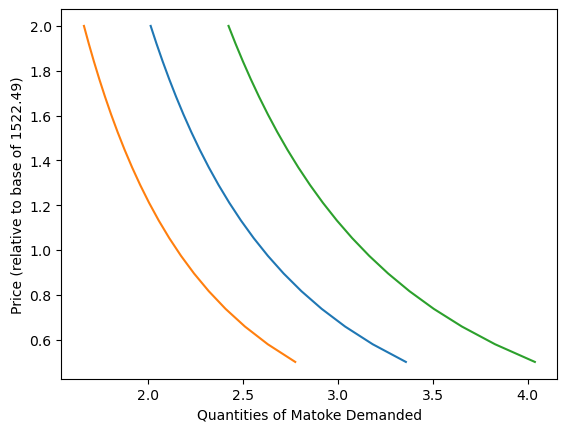

In [17]:
import matplotlib.pyplot as plt

use = 'Matoke'  # Good we want demand curve for

# Vary prices from 50% to 200% of reference.
scale = np.linspace(.5,2,20)

# Demand for Matoke for household at median budget
plt.plot([r.demands(xref,my_prices(use,pbar[use]*s,pbar))[use] for s in scale],scale)

# Demand for Matoke for household at 25% percentile
plt.plot([r.demands(xbar.quantile(0.25),my_prices(use,pbar[use]*s,pbar))[use] for s in scale],scale)

# Demand for Matoke for household at 75% percentile
plt.plot([r.demands(xbar.quantile(0.75),my_prices(use,pbar[use]*s,pbar))[use] for s in scale],scale)

plt.ylabel(f"Price (relative to base of {pbar[use]:.2f})")
plt.xlabel(f"Quantities of {use} Demanded")

#### Engel Curves



/srv/conda/lib/python3.11/site-packages/consumerdemands/root_with_precision.py:83: UserWarning: Tolerance is set to 1.00E-12.  Change in value is -3.64E-12.  Iterations are 1001.  Perhaps tolerance is too high?
  warn("Tolerance is set to %.2E.  Change in value is %.2E.  Iterations are %d.  Perhaps tolerance is too high?" % (tol,x[0]-x[-1],i))


Text(0.5, 1.0, 'Engel Curves')

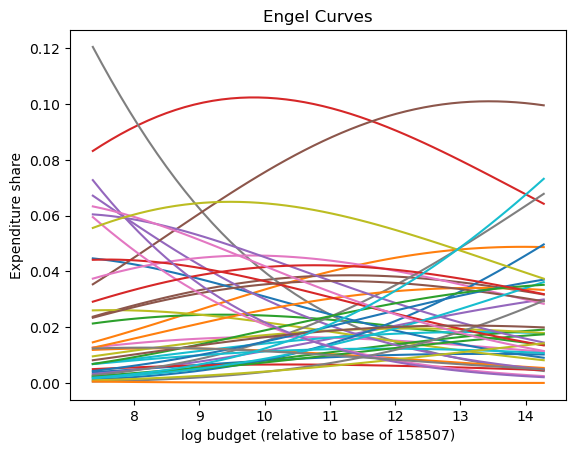

In [18]:
fig,ax = plt.subplots()

scale = np.geomspace(.01,10,50)

ax.plot(np.log(scale*xref),[r.expenditures(s*xref,pbar)/(s*xref) for s in scale])
ax.set_xlabel(f'log budget (relative to base of {xref:.0f})')
ax.set_ylabel(f'Expenditure share')
ax.set_title('Engel Curves')

### Mapping to Nutrients



We&rsquo;ve seen how to map prices and budgets into vectors of consumption
 quantities using `cfe.Regression.demands`.  Next we want to think about
 how to map these into bundles of *nutrients*.  The information needed
 for the mapping comes from a &ldquo;Food Conversion Table&rdquo; (or database,
 such as the [USDA Food Data Central](https://fdc.nal.usda.gov/)).    We&rsquo;ve already grabbed an FCT, let&rsquo;s take a look:



In [19]:
fct

n,Energy,Protein,Fiber,Folate,Calcium,Carbohydrate,Iron,Niacin,Riboflavin,Thiamin,Vitamin A,Vitamin B-12,Vitamin B-6,Vitamin C,Zinc,Magnesium,Phosphorus,Potassium,Vitamin E,Vitamin K
j,,,,,,,,,,,,,,,,,,,,
Apples,617.893,1.875,20.43,0,46.56,147.817,0.0,0.90,0.6625,0.0875,0,0.0,0.2131,0,0.1964,46.95,91.83,953.1,0.0,0
Avocado,1600.000,20.000,70.00,810,120.00,85.000,6.0,17.38,1.3000,0.6700,70,0.0,2.5700,100,6.0000,0.00,0.00,0.0,0.0,0
Beans (dry),1700.000,98.000,60.00,500,580.00,325.000,30.0,7.00,1.2000,3.4000,0,0.0,2.1500,10,8.0000,0.00,0.00,0.0,0.0,0
Beans (fresh),3470.000,214.000,160.00,5250,1130.00,626.000,51.0,11.74,2.1200,7.1300,0,0.0,4.7400,63,23.0000,0.00,0.00,0.0,0.0,0
Beef,2510.000,182.000,0.00,60,70.00,0.000,19.0,31.50,1.6000,0.9000,0,28.9,3.8000,0,37.0000,0.00,0.00,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Water,0.000,0.000,0.00,0,30.00,0.000,0.0,0.00,0.0000,0.0000,0,0.0,0.0000,0,0.1000,10.00,0.00,0.0,0.0,0
Watermelon,300.000,6.100,4.00,30,70.00,75.500,2.4,1.78,0.2100,0.3300,280,0.0,0.4500,81,1.0000,0.00,0.00,0.0,0.0,0
Wheat (flour),3640.000,103.000,30.00,260,150.00,763.000,12.0,12.50,0.4000,1.2000,0,0.0,0.4400,0,7.0000,0.00,0.00,0.0,0.0,0


We need the index of the Food Conversion Table (FCT) to match up with
 the index of the vector of quantities demanded.   To manage this we
 make use of the `align` method for `pd.DataFrames`:



In [20]:
# Create a new FCT and vector of consumption that only share rows in common:
fct0,c0 = fct.align(qhat.T,axis=0,join='inner')
print(fct0.index)

Index(['Avocado', 'Beans (dry)', 'Beans (fresh)', 'Beef', 'Bogoya', 'Bread',
       'Cabbage (green)', 'Cassava (dry)', 'Cassava (fresh)', 'Chapati',
       'Cooking Oil (refined)', 'Dodo', 'Donuts', 'Eggplant', 'Eggs',
       'Goat Meat', 'Ground Nuts (pounded)', 'Ground Nuts (shelled)',
       'Irish Potatoes', 'Jam/Marmalade', 'Maize (cobs)', 'Maize (flour)',
       'Mangos', 'Matoke', 'Millet Flour', 'Mukene', 'Onions', 'Oranges',
       'Pumpkins', 'Rice', 'Salt', 'Restaurant (soda)',
       'Sweet Potatoes (fresh)', 'Tea (leaves)', 'Tomatoes', 'Waragi',
       'Yams (arrowroot)'],
      dtype='object', name='j')


Now, since rows of `fct0` and `c0` match, we can obtain nutritional
 outcomes from the inner (or dot, or matrix) product of the transposed
 `fct0` and `c0`:



In [21]:
# The @ operator means matrix multiply
N = fct0.T@c0

N  #NB: Uganda quantities are for previous 7 days

i,0007d1f1449242feb5a25429644fb991,0010cbae3cea4ec9831f6cd92b02dc16,00246782f8654441a9df0f6ec0b6fc9f,005fbc5779014a0290b088071bde9f72,009c1baa0edb44f8af47773ce0b7caaa,00b48fb6bcf84dd581bd7b2be5f908a0,00c2b27287a74f948fef24a8de42825c,00cb487f12014891b3efa5c8679d18ab,00d5da8bbd544c548a71f176496ee4b6,00dc3a212a1f40698656b2dc7cc97a85,...,fef6a31f5c8542aead247c12573e0307,ff3346434ae6489fa2dc81e9df5a84db,ff5869d3420643fbbdb7897ea89d009f,ff62baaeffbf44029f0e689447dafca9,ff6c8b1a47334dc88d74ee0f5e2d880c,ff77648719664071a4e363956db92c08,ff8b330984bc466aaf2366c3eea3d8cc,ffb33b3ededa4019a02be24224ab0440,ffea6d0233164dd3afe28545f2cbb5f9,ffec87c6ae87498f956723afe69266b9
t,2019-20,2019-20,2019-20,2019-20,2019-20,2019-20,2019-20,2019-20,2019-20,2019-20,...,2019-20,2019-20,2019-20,2019-20,2019-20,2019-20,2019-20,2019-20,2019-20,2019-20
m,Northern,Northern,Northern,Central,Western,Central,Central,Northern,Northern,Eastern,...,Western,Central,Northern,Northern,Eastern,Eastern,Northern,Western,Central,Eastern
n,,,,,,,,,,,,,,,,,,,,,
Energy,199065.428660,115400.289742,98233.194565,116095.454583,124673.117935,124270.816912,138623.056593,73713.191397,236745.138011,159605.121342,...,165750.013254,178125.147981,307413.672423,172376.267277,125045.668992,103307.811203,313105.949511,216275.578171,86445.571046,154299.067585
Protein,3933.420432,2308.031983,1698.978072,2321.086910,2758.489225,2481.925174,2972.475172,1434.071144,4483.769569,2719.026225,...,3363.094065,3701.905480,6104.634583,3203.690664,2198.445447,1893.787233,6050.323803,4794.551015,1667.027491,2795.608815
Fiber,2933.992009,1619.791444,1288.941709,1617.342531,2000.390486,1732.766533,2214.901211,999.395217,3321.920302,2270.857056,...,2412.607765,2609.708695,4777.461396,2382.165810,1700.087776,1431.279045,4923.021179,3449.748416,1129.248139,2169.429787
Folate,39550.301396,24179.851897,19352.432318,25541.776036,36788.567844,27250.738629,38327.932099,15067.558176,49562.800641,30699.938051,...,41236.427617,42709.112802,69976.780458,33318.511744,24161.939390,20889.953777,69021.445208,53234.210931,18502.001024,29966.453122
Calcium,24573.161426,15031.718456,11875.391686,16886.419612,18384.759989,18016.673911,20550.357310,9559.183976,28750.111195,21041.027958,...,22191.872478,25450.998776,38272.295474,20493.792164,16142.849236,14029.807487,42233.691704,30133.379210,12186.028417,20125.734425
Carbohydrate,28006.694167,15172.960232,13045.641862,13973.618284,15511.607492,14957.355957,18396.664008,9928.901273,30626.311492,23120.098531,...,19896.808707,21940.390063,42202.537744,22764.605897,16856.955434,13586.829840,48586.473062,30070.379887,9904.986396,20567.263290
Iron,1032.343149,593.114796,475.980638,577.918623,684.632586,618.041856,753.200153,378.362907,1176.510546,770.869753,...,835.511238,915.948672,1624.011894,851.091394,592.753117,495.148018,1680.185029,1193.164772,415.280591,731.422726


Of course, since we can compute the nutritional content of a vector of
 consumption goods `c0`, we can also use our demand functions to
 compute nutrition as a *function* of prices and budget.



In [22]:
def nutrient_demand(x,p):
    c = r.demands(x,p)
    fct0,c0 = fct.align(c,axis=0,join='inner')
    N = fct0.T@c0

    N = N.loc[~N.index.duplicated()]
    
    return N

With this `nutrient_demand` function in hand, we can see how nutrient
 outcomes vary with budget, given prices:



Text(0, 0.5, 'log nutrient')

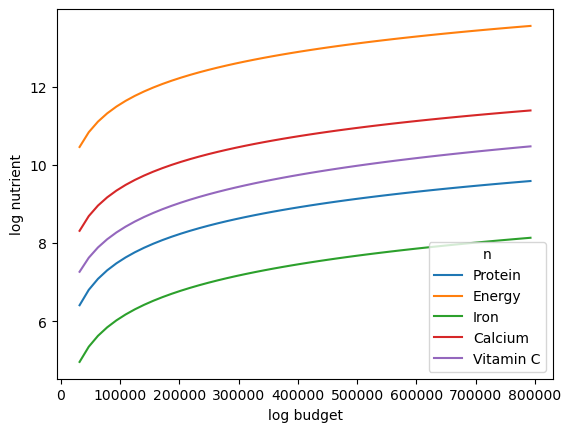

In [23]:
import numpy as np
import matplotlib.pyplot as plt

X = np.linspace(xref/5,xref*5,50)

UseNutrients = ['Protein','Energy','Iron','Calcium','Vitamin C']

df = pd.concat({myx:np.log(nutrient_demand(myx,pbar))[UseNutrients] for myx in X},axis=1).T
ax = df.plot()

ax.set_xlabel('log budget')
ax.set_ylabel('log nutrient')

Now how does nutrition vary with prices?



Text(0, 0.5, 'log nutrient')

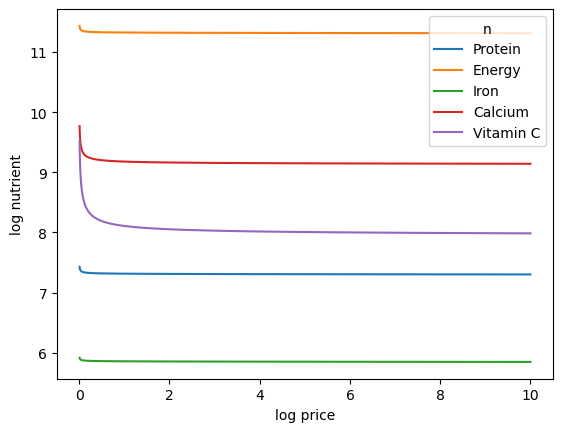

In [24]:
USE_GOOD = 'Oranges'

scale = np.geomspace(.01,10,50)

ndf = pd.DataFrame({s:np.log(nutrient_demand(xref/2,my_prices(USE_GOOD,pbar[USE_GOOD]*s)))[UseNutrients] for s in scale}).T

ax = ndf.plot()

ax.set_xlabel('log price')
ax.set_ylabel('log nutrient')

### Nutritional Needs of Households



Our data on demand and nutrients is at the *household* level; we
   can&rsquo;t directly compare household level nutrition with individual
   level requirements.  What we **can** do is add up minimum individual
   requirements, and see whether household total exceed these.  This
   isn&rsquo;t a guarantee that all individuals have adequate nutrition
   (since the way food is allocated in the household might be quite
   unequal, or unrelated to individual requirements), but it is
   *necessary* if all individuals are to have adequate nutrition.

For the average household in our data, the number of
different kinds of people can be computed by averaging over households:



In [25]:
# In first round, averaged over households and villages
dbar = r.d[rdi.columns].mean()

Now, the inner/dot/matrix product between `dbar` and the `rdi`
DataFrame of requirements will give us minimum requirements for the
average household:



In [27]:
# This matrix product gives minimum nutrient requirements for
# the average household
hh_rdi = rdi@dbar

hh_rdi

n
Energy           9426.980728
Protein           210.338758
Fiber             131.977730
Folate           1765.010707
Calcium          5769.379015
Carbohydrate      701.610278
Iron               57.648822
Magnesium        1511.503212
Niacin             67.335332
Phosphorus       4355.130621
Potassium       23487.066381
Riboflavin          5.274604
Thiamin             5.124111
Vitamin A        3517.259101
Vitamin B-12       10.590064
Vitamin B-6         5.854433
Vitamin C         316.717345
Vitamin E          65.763597
Vitamin K         419.612420
Zinc               42.732334
dtype: float64

## Nutritional Adequacy of Food Demands



Since we can trace out demands for nutrients as a function of $(x,p)$,
and we&rsquo;ve computed minimum nutritional requirements for the average
household, we can *normalize* nutritional intake to check the adequacy
of diet for a household with counts of different kinds of people given by `z`.



In [28]:
def nutrient_adequacy_ratio(x,p,d,rdi=rdi,days=7):
    hh_rdi = rdi.replace('',0)@d*days

    return nutrient_demand(x,p)/hh_rdi

In terms of normalized nutrients, any household with more than one
unit of any given nutrient (or zero in logs) will be consuming a
minimally adequate level of the nutrient; below this level there&rsquo;s
clearly nutritional inadequacy.  For this reason the ratio of
actual nutrients to required nutrients is termed the &ldquo;nutrient
adequacy ratio,&rdquo; or NAR.



/srv/conda/lib/python3.11/site-packages/consumerdemands/root_with_precision.py:83: UserWarning: Tolerance is set to 1.00E-12.  Change in value is -7.28E-12.  Iterations are 1001.  Perhaps tolerance is too high?
  warn("Tolerance is set to %.2E.  Change in value is %.2E.  Iterations are %d.  Perhaps tolerance is too high?" % (tol,x[0]-x[-1],i))


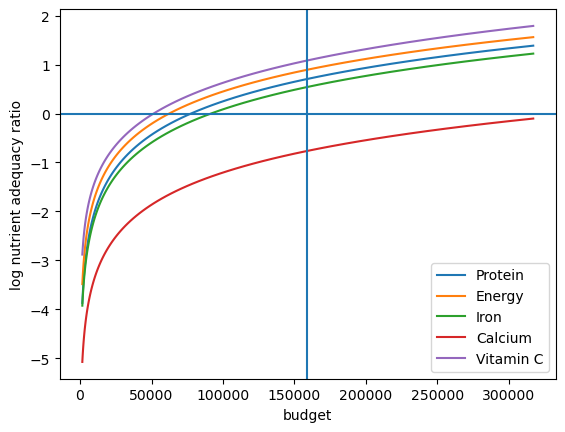

In [29]:
X = np.geomspace(.01*xref,2*xref,100)

pd.DataFrame({x:np.log(nutrient_adequacy_ratio(x,pbar,dbar))[UseNutrients] for x in X}).T.plot()
plt.legend(UseNutrients)
plt.xlabel('budget')
plt.ylabel('log nutrient adequacy ratio')
plt.axhline(0)
plt.axvline(xref)

Do research on effectiveness of cash transfers -> how directly will they impact nutritional outcomes and would some subsidies be better?

As before, we can also vary relative prices.  Here we trace out
nutritional adequacy varying the price of a single good:



Text(0.5, 0, 'log nutrient adequacy ratio')

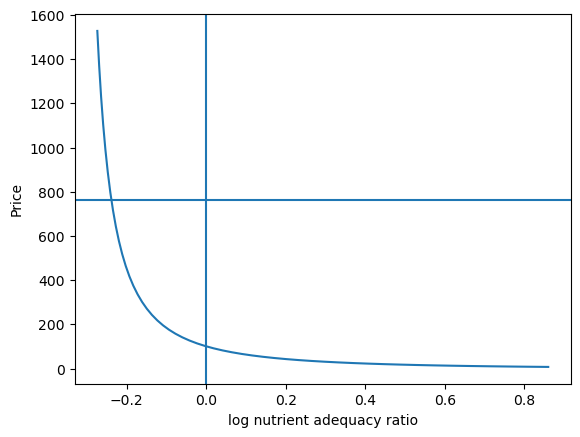

In [30]:
scale = np.geomspace(.01,2,50)

ndf = pd.DataFrame({s*pbar[USE_GOOD]:np.log(nutrient_adequacy_ratio(xref/4,my_prices(USE_GOOD,pbar[USE_GOOD]*s),dbar))[UseNutrients] for s in scale}).T

fig,ax = plt.subplots()
ax.plot(ndf['Vitamin C'],ndf.index)
ax.axhline(pbar[USE_GOOD])
ax.axvline(0)

ax.set_ylabel('Price')
ax.set_xlabel('log nutrient adequacy ratio')